# Reducing the number of CH$\mathrm{_4}$ lines using pseudo-line generator (plg)
Tako Ishikawa  
last update: 2022/06/13   
created: : 2022/05/07　　

In [1]:
import os; os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
import numpy as np
import jax.numpy as jnp
from exojax.spec import plg
from exojax.spec import moldb, contdb, molinfo
from exojax.utils.grids import gen_wavenumber_grid
from exojax.spec import initspec
import matplotlib.pyplot as plt
import time
import copy
#path_fig = '/home/tako/Dropbox/tmpfig/'

Set parameters used to make elower grid.

In [2]:
Nelower = 7 #number of division of elower grid 
Tgue = 1300. #rough guess on the typical atmospheric temperature of the object you analyze
errTgue = 500. #expected one-sided error of Tgue
Tmargin=500. #upper margin even above Tgue+errTgue to prevent freeze of lines that  become strong enough as temperature rises slightly. (more needed for cooler objects; Note that it is a tradeoff between accuracy and compression rate)

Set a wavenumber grid using nugrid. 

In [3]:
wls, wll, nugrid_res = 16448.0, 16452.0, 0.05
nus, wav, reso = gen_wavenumber_grid(wls, wll, int((wll-wls)/nugrid_res), unit="AA", xsmode="modit")

xsmode assumes ESLOG: mode= modit


Load a molecular database of CH4 and CIA (H2-H2).

In [4]:
mdb_orig = moldb.MdbExomol('.database/CH4/12C-1H4/YT10to10/', nus, \
                           crit=0, Ttyp=Tgue) #1.e-40
mdb = copy.deepcopy(mdb_orig)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)
molmassCH4=molinfo.molmass("CH4")
print("Nline=", len(mdb_orig.A)) #chk

Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a1
default broadening parameters are used for  23  J lower states in  40  states
H2-H2
Nline= 1613197


Optimize the parameter "coefTgue" which is used to adjust the temperature referenced when creating the elower grid.

In [5]:
#To save computation time, let us use only the middle 1 Å width to optimize coefTgue here.
assess_width = 1. #Note that too narrow (e.g., 1. Å) might cause a ValueError. (#Cause unspecified...)
nusc, wavc, resoc = gen_wavenumber_grid( (wll+wls-assess_width)/2, (wll+wls+assess_width)/2, 20, unit="AA", xsmode="modit")
mdbc = moldb.MdbExomol('.database/CH4/12C-1H4/YT10to10/', nusc)

ts = time.time()
coefTgue = plg.optimize_coefTgue(Tgue, nusc, mdbc, molmassCH4, Nelower, errTgue)
te = time.time()
print(te-ts, "sec for", len(mdbc.A), "lines,  coefTgue =", coefTgue)

#GPU Memory Usage ~ 2377 MiB up to here.

xsmode assumes ESLOG: mode= modit
Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a1
default broadening parameters are used for  23  J lower states in  40  states
132.168860912323 sec for 403277 lines,  coefTgue = 0.6724916420549382


Precompute the contribution for wavenumber.

In [6]:
cnu,indexnu,R,pmarray = initspec.init_modit(mdb.nu_lines,nus)
cnu_orig = copy.deepcopy(cnu)
indexnu_orig = copy.deepcopy(indexnu)

Make grids of parameters for Lorentzian width and an associated index.

In [7]:
alpha_ref_grid, n_Texp_grid, index_gamma = plg.make_gamma_grid_exomol(mdb)
Ngamma = len(alpha_ref_grid)

Generate pseudo lines by combining many weak lines in the same bin of the 3-d grid of elower, nu, and gamma.

In [8]:
ts = time.time()
qlogsij0, qcnu, num_unique, elower_grid, frozen_mask, nonzeropl_mask = plg.plg_elower_addcon(\
    index_gamma, Ngamma, cnu, indexnu, nus, mdb, Tgue, errTgue, \
    Nelower=Nelower, Tmargin=Tmargin, coefTgue=coefTgue)    
te = time.time()
print(te-ts, "sec")
print("elower_grid", elower_grid)

# of original lines: 1613197
# of unfrozen lines: 171050
# of frozen lines: 1442147
# of pseudo lines: 9723
# of total lines: 180773
# compression: 0.11205884960113364
1.6579194068908691 sec
elower_grid [ 103.7740097  7512.99274649 7701.75119962 7812.1678164  7890.50965275
 7951.27630197 8000.92626953]


Gather pseudo lines and unfrozen lines into a single molecular database (mdb).

In [9]:
mdb, cnu, indexnu = plg.gather_lines(mdb, Ngamma, len(nus), Nelower, nus, cnu, indexnu, qlogsij0, qcnu, elower_grid, alpha_ref_grid, n_Texp_grid, frozen_mask, nonzeropl_mask)

The pseudo-line generator is finished here.

## Try calculating spectra using the output mdb and compare it with the original.

Prepare for radiative transfer calculation.

In [10]:
from exojax.spec import rtransfer as rt
from exojax.spec import modit
from exojax.spec.modit import set_ditgrid_matrix_exomol
from exojax.spec.rtransfer import rtrun, dtauM, dtauCIA
from exojax.spec import planck, response

#Assume atmosphere.
NP=100
Parr, dParr, k=rt.pressure_layer(NP=NP)
mmw=2.33 #mean molecular weight
mmrH2=0.74 #mass mixing ratio
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #volume mixing ratio
Pref=1.0 #bar
ONEARR=np.ones_like(Parr)

#a core driver
def frun(Tarr,MMR_,Mp,Rp,u1,u2,RV,vsini):
    g=2478.57730044555*Mp/Rp**2
    SijM_,ngammaLM_,nsigmaDl_=modit.exomol(mdb,Tarr,Parr,R,molmassCH4)
    xsm_=modit.xsmatrix(cnu,indexnu,R,pmarray,nsigmaDl_,ngammaLM_,SijM_,nus,dgm_ngammaL)
    dtaum=dtauM(dParr,jnp.abs(xsm_),MMR_*ONEARR,molmassCH4,g) #abs is used to remove negative values in xsv
    #CIA
    dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)
    dtau=dtaum+dtaucH2H2
    sourcef = planck.piBarr(Tarr,nus)
    F0=rtrun(dtau,sourcef)
    Frot=response.rigidrot(nus,F0,vsini,u1,u2)
    #mu=response.ipgauss_sampling(nusd,nus,Frot,beta_inst,RV)
    mu=Frot
    return mu

#Precompute gdm_ngammaL.
fT = lambda T0,alpha: T0[:,None]*(Parr[None,:]/Pref)**alpha[:,None]
T0_test=np.array([Tgue-300.,Tgue+300.,Tgue-300.,Tgue+300.])
alpha_test=np.array([0.2,0.2,0.05,0.05])
res=0.2
dgm_ngammaL=set_ditgrid_matrix_exomol(mdb,fT,Parr,R,molmassCH4,res,T0_test,alpha_test)

#GPU Memory Usage ~ 2377 MiB up to here.

Prepare the same for the original mdb before reducing the number of absorption lines.

In [11]:
#a core driver for original mdb
def frun_orig(Tarr, MMR_, Mp, Rp, u1, u2, RV, vsini):
    g = 2478.57730044555*Mp/Rp**2
    SijM_, ngammaLM_, nsigmaDl_ = modit.exomol(mdb_orig, Tarr, Parr, R, molmassCH4)
    xsm_ = modit.xsmatrix(cnu_orig, indexnu_orig, R, pmarray, nsigmaDl_, ngammaLM_, SijM_, nus, dgm_ngammaL_orig)
    dtaum = dtauM(dParr, jnp.abs(xsm_), MMR_*ONEARR, molmassCH4, g) #abs is used to remove negative values in xsv
    #CIA
    dtaucH2H2 = dtauCIA(nus, Tarr, Parr, dParr, vmrH2, vmrH2, mmw, g, cdbH2H2.nucia, cdbH2H2.tcia, cdbH2H2.logac)
    dtau = dtaum+dtaucH2H2
    sourcef  =  planck.piBarr(Tarr, nus)
    F0 = rtrun(dtau, sourcef)
    Frot = response.rigidrot(nus, F0, vsini, u1, u2)
    #mu = response.ipgauss_sampling(nusd, nus, Frot, beta_inst, RV)
    mu = Frot
    return mu

#Precompute gdm_ngammaL for original mdb.
dgm_ngammaL_orig = set_ditgrid_matrix_exomol(mdb_orig, fT, Parr, R, molmassCH4, res, T0_test, alpha_test)

#GPU Memory Usage ~ 8521 MiB up to here.

Set stellar parameters.

In [12]:
#Example with Luhman 16 A parameters (from Kawahara+2022)
MpBd = 33.2
RpBd = 0.89
MMR_rough = 0.0059 #(referring to MMR_CO)
plotTF = False

#Test with other parameters
#MpBd = 33.2; RpBd = 0.88; MMR_rough = 0.0059; plotTF=False
#MpBd = 162.3; RpBd = 1.85; MMR_rough = 0.001; plotTF=False
#MpBd = 41.; RpBd = 1.; MMR_rough = 0.001; plotTF=False

Calcuate and plot spectra.

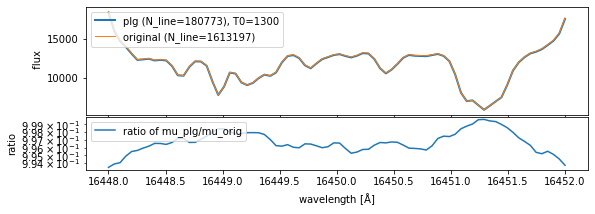

In [13]:
Tarr = Tgue*(Parr/Pref)**0.1
mu=frun(Tarr,MMR_=MMR_rough,Mp=MpBd,Rp=RpBd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)
mu_orig = frun_orig(Tarr,MMR_=MMR_rough,Mp=MpBd,Rp=RpBd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)

llow, lhigh, tip = wls, wll, 0.2

fig=plt.figure(figsize=(9,3))
ax=plt.subplot2grid((12, 1), (0, 0),rowspan=8)

plt.plot(wav[::-1], mu, label=f"plg (N_line={len(mdb.A):>5}), T0={int(Tgue):>4}", lw=2.0)
plt.plot(wav[::-1], mu_orig, '-', label=f"original (N_line={len(mdb_orig.A):>5})", lw=1.0)

plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.legend(loc="upper left")
plt.ylabel(" flux",fontsize=10)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')

ax=plt.subplot2grid((12, 1), (8, 0),rowspan=4)
plt.plot(wav[::-1], mu/mu_orig, label=f"ratio of mu_plg/mu_orig")
plt.yscale("log")
plt.ylabel("ratio",fontsize=10)
plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')
plt.legend(loc="upper left")

if plotTF:
    plt.savefig(path_fig + "ch4plg_tutorial.pdf", bbox_inches="tight")#, pad_inches=0.0)
plt.show()

## Additional check (Tshift)
Doesn't it matter if the actual temperatures deviate from Tgue?

800.0


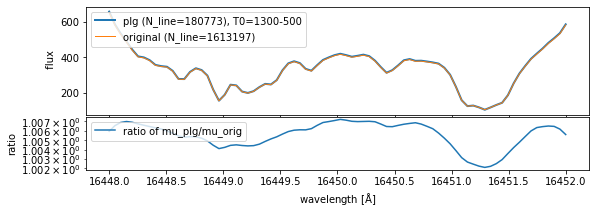

In [14]:
Tshift = -errTgue
print(Tgue + Tshift)

Tarr = (Tgue+Tshift)*(Parr/Pref)**0.1
mu=frun(Tarr,MMR_=MMR_rough,Mp=MpBd,Rp=RpBd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)
mu_orig = frun_orig(Tarr,MMR_=MMR_rough,Mp=MpBd,Rp=RpBd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)

fig=plt.figure(figsize=(9,3))
ax=plt.subplot2grid((12, 1), (0, 0),rowspan=8)

plt.plot(wav[::-1], mu, label=f"plg (N_line={len(mdb.A):>5}), T0={int(Tgue):>4}{int(Tshift):+}", lw=2.0)
plt.plot(wav[::-1], mu_orig, '-', label=f"original (N_line={len(mdb_orig.A):>5})", lw=1.0)

plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.legend(loc="upper left")
plt.ylabel(" flux",fontsize=10)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')

ax=plt.subplot2grid((12, 1), (8, 0),rowspan=4)
plt.plot(wav[::-1], mu/mu_orig, label=f"ratio of mu_plg/mu_orig")
plt.yscale("log")
plt.ylabel("ratio",fontsize=10)
plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')
plt.legend(loc="upper left")

if plotTF:
    plt.savefig(path_fig + f"ch4plg_tutorial_Tshift{int(Tshift):+}.pdf", bbox_inches="tight")#, pad_inches=0.0)
plt.show()

1800.0


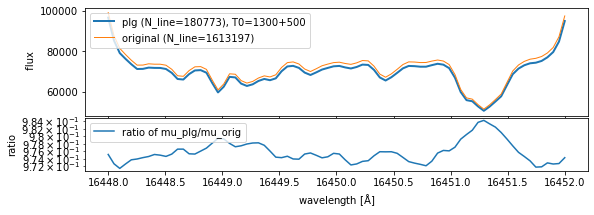

In [15]:
Tshift = +errTgue
print(Tgue + Tshift)

Tarr = (Tgue+Tshift)*(Parr/Pref)**0.1
mu=frun(Tarr,MMR_=MMR_rough,Mp=MpBd,Rp=RpBd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)
mu_orig = frun_orig(Tarr,MMR_=MMR_rough,Mp=MpBd,Rp=RpBd,u1=0.0,u2=0.0,RV=10.0,vsini=0.1)

fig=plt.figure(figsize=(9,3))
ax=plt.subplot2grid((12, 1), (0, 0),rowspan=8)

plt.plot(wav[::-1], mu, label=f"plg (N_line={len(mdb.A):>5}), T0={int(Tgue):>4}{int(Tshift):+}", lw=2.0)
plt.plot(wav[::-1], mu_orig, '-', label=f"original (N_line={len(mdb_orig.A):>5})", lw=1.0)

plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.legend(loc="upper left")
plt.ylabel(" flux",fontsize=10)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')

ax=plt.subplot2grid((12, 1), (8, 0),rowspan=4)
plt.plot(wav[::-1], mu/mu_orig, label=f"ratio of mu_plg/mu_orig")
plt.yscale("log")
plt.ylabel("ratio",fontsize=10)
plt.xlim(llow*1.0-tip,lhigh*1.0+tip)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')
plt.legend(loc="upper left")

if plotTF:
    plt.savefig(path_fig + f"ch4plg_tutorial_Tshift{int(Tshift):+}.pdf", bbox_inches="tight")#, pad_inches=0.0)
plt.show()